<a href="https://colab.research.google.com/github/Chada2307/MoodTracker/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
import zipfile
import os

##drive.mount('/content')  # Podłączanie Dysku Google
data_path = "/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train"  # Ścieżka do pliku

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/")

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train'

In [6]:
os.listdir("/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [7]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [8]:
data_dir = "/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt"

batch_size=16
num_workers = 2

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

Train dataset size: 28709 images
Test dataset size: 7178 images


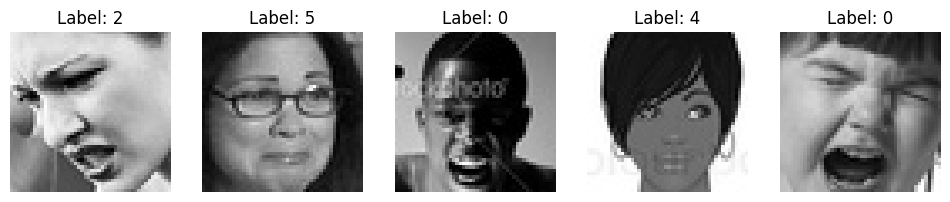

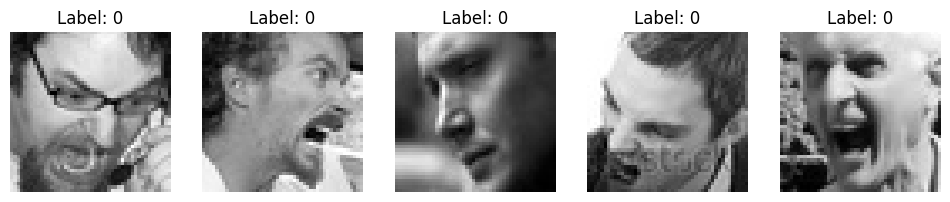

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

dataiter1 = iter(test_loader)
images, labels = next(dataiter1)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class EmocjeCNN(nn.Module):
  def __init__(self):
    super(EmocjeCNN,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    ##self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64 * 12 * 12 , 256)
    self.fc2 = nn.Linear(256, 7)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    ##x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 64 * 12 * 12)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [15]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmocjeCNN().to(device)

kryteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

print("GPU dostępne:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



GPU dostępne: False
Nazwa GPU: Brak GPU


In [14]:
from sklearn.metrics import accuracy_score
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


scaler = torch.amp.GradScaler()
model.to(device)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(images)
            loss = kryteria(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        accuracy = calculate_accuracy(outputs, labels)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)


    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = kryteria(outputs, labels)
            val_loss += loss.item()

            accuracy = calculate_accuracy(outputs, labels)
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)


    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

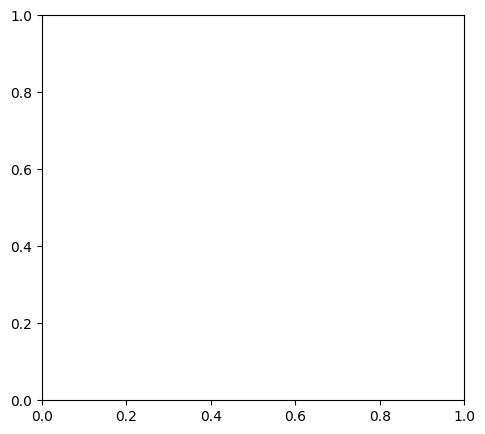

In [60]:
plt.figure(figsize=(12, 5))

# Wykres treningu i walidacji loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", color="red")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Wykres treningu i walidacji accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", color="red")
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

In [57]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 82.00%


In [58]:
from PIL import Image
def predict_emotion(image_path):
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    emotion_labels = ['angry','disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    return emotion_labels[predicted.item()]

print(predict_emotion("/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train/angry/1.jpg"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train/angry/1.jpg'

In [37]:
import time

start_time = time.time()

for i, (images, labels) in enumerate(train_loader):
    if i == 5:  # Pobranie tylko 5 batchy, żeby zobaczyć czas
        break

print(f"Czas wczytania 5 batchy: {time.time() - start_time:.2f} sekund")


Czas wczytania 5 batchy: 58.79 sekund
